<a href="https://colab.research.google.com/github/developerabhi14/ML-Notebooks/blob/main/MNIST_Digit_Classification_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# --- Data Transform ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Standard normalization for MNIST
])


# --- Load Datasets ---
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 340kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.21MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.65MB/s]


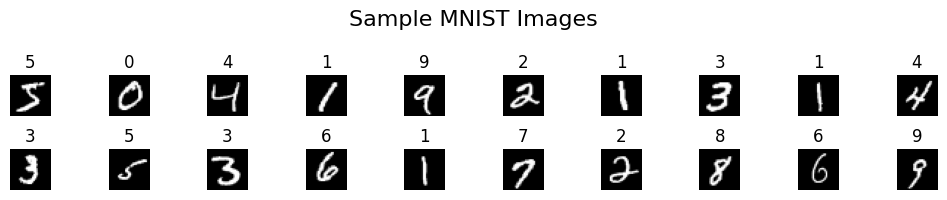

In [3]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# --- EDA: Show image samples ---
def show_samples(dataset, n=20):
    plt.figure(figsize=(10, 2))
    for i in range(n):
        image, label = dataset[i]
        plt.subplot(2, n//2, i+1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.suptitle("Sample MNIST Images", fontsize=16)
    plt.tight_layout()
    plt.show()

show_samples(train_dataset)

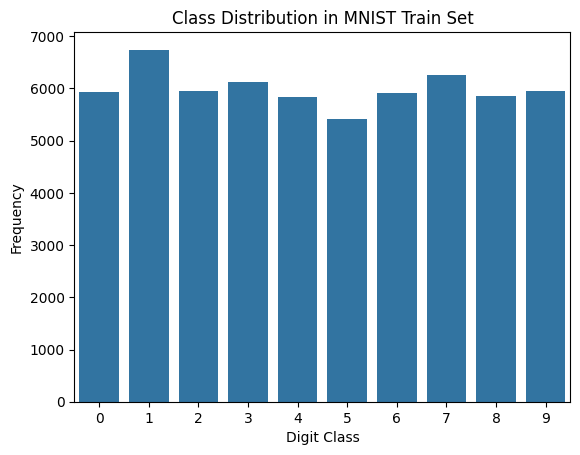

In [4]:
# --- EDA: Check class distribution ---
labels = [label for _, label in train_dataset]
sns.countplot(x=labels)
plt.title("Class Distribution in MNIST Train Set")
plt.xlabel("Digit Class")
plt.ylabel("Frequency")
plt.show()

In [5]:
# --- CNN Model Definition ---
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

model = CNNModel()

In [6]:
# --- Loss and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# --- Training Loop ---
epochs = 5
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/5], Loss: 0.1656
Epoch [2/5], Loss: 0.0526
Epoch [3/5], Loss: 0.0345
Epoch [4/5], Loss: 0.0252
Epoch [5/5], Loss: 0.0202


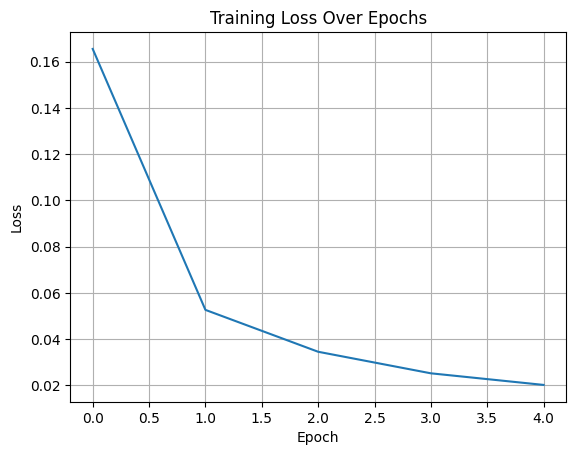

In [8]:
# --- Plot Training Loss ---
plt.plot(train_losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [9]:
# --- Evaluation ---
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Accuracy & Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.98      1.00      0.99      1032
           3       0.99      0.99      0.99      1010
           4       1.00      0.97      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.97      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



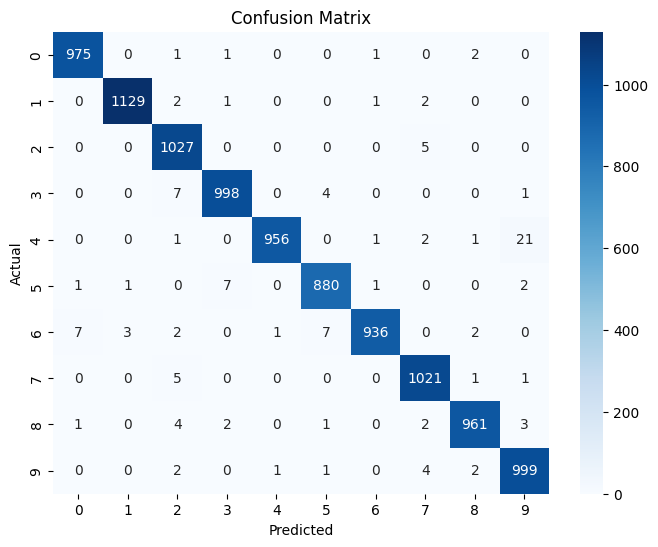

In [10]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

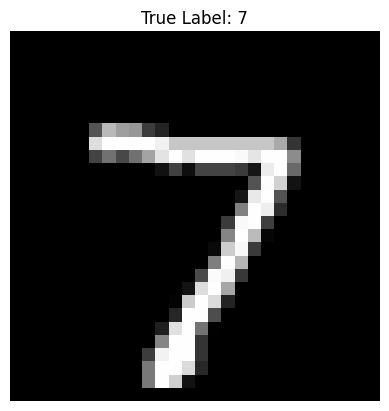

Predicted Class: 7


In [11]:
# --- Inference on One Image ---
sample_img, sample_label = test_dataset[0]
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f"True Label: {sample_label}")
plt.axis('off')
plt.show()

sample_tensor = sample_img.unsqueeze(0)
with torch.no_grad():
    output = model(sample_tensor)
    predicted_class = torch.argmax(output).item()
    print(f"Predicted Class: {predicted_class}")